In [1]:
import skysurvey
import numpy as np
import sncosmo
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import corner
import pandas
from code import *
from tqdm.notebook import tqdm
import time
import healpy

In [2]:
import warnings
from iminuit.warnings import IMinuitWarning
warnings.filterwarnings('ignore', category=IMinuitWarning) 

In [6]:
%matplotlib inline

# skysurvey tests

In [3]:
snia = skysurvey.SNeIa()

In [4]:
data = snia.draw(size=10_000, inplace=True)

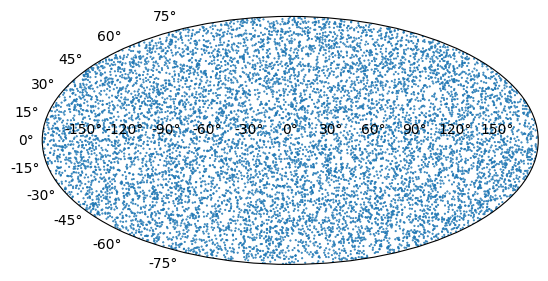

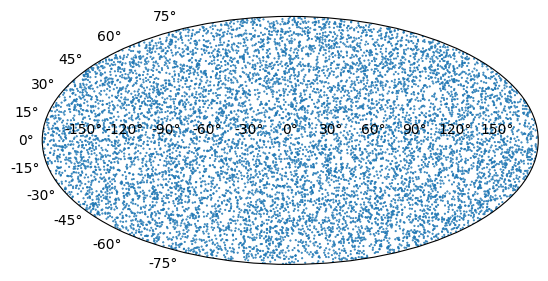

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

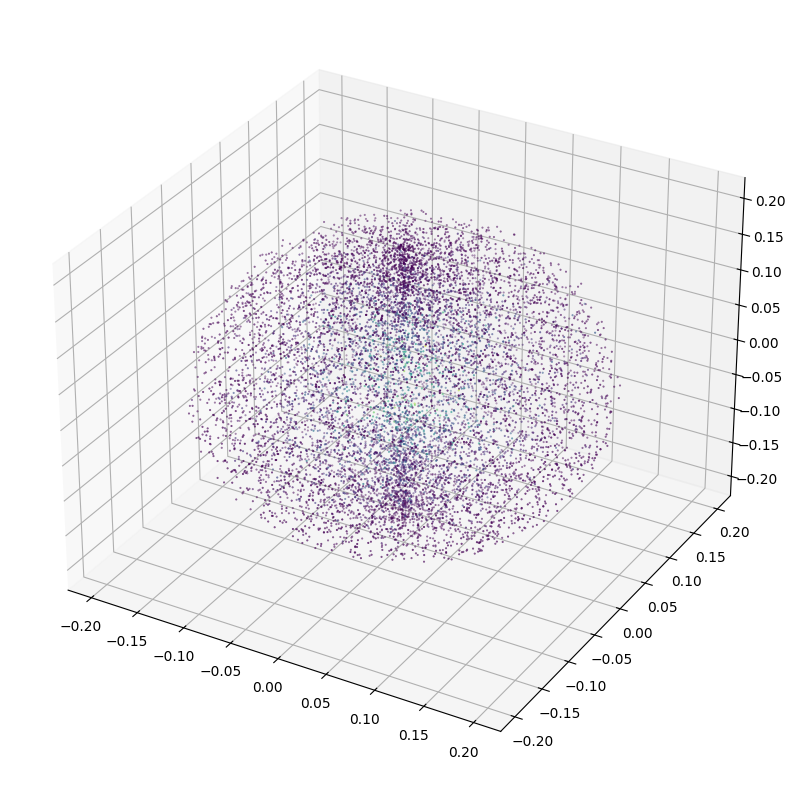

In [8]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_tree(
    pts: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(pts, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_tree(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

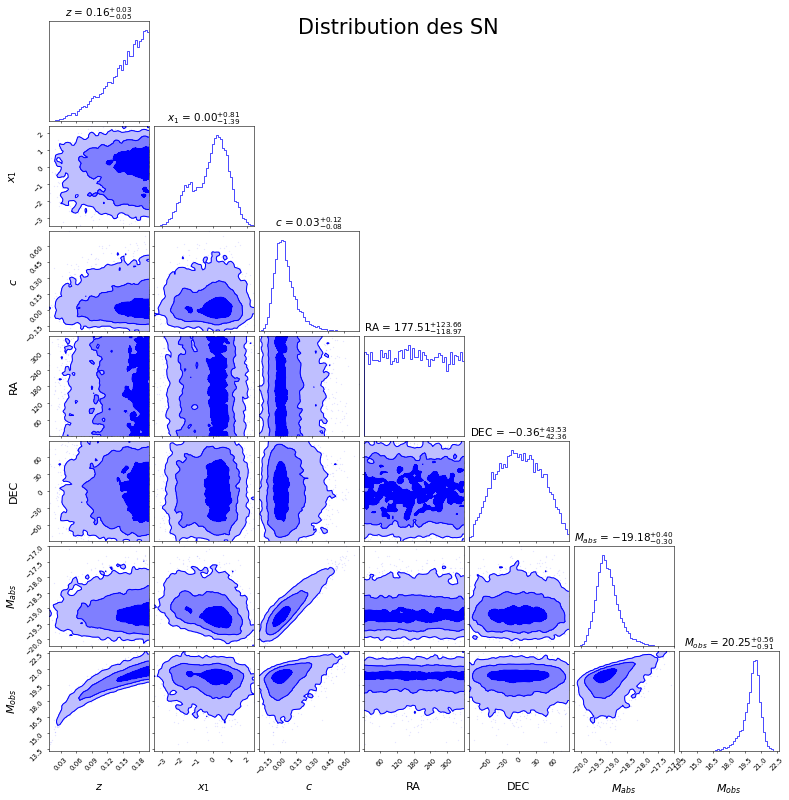

In [9]:
fig = corner_(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$M_{abs}$", r"$M_{obs}$"],
    title='Distribution des SN',
)

In [10]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

In [12]:
import pickle

with open('data/ztf_survey.pkl','rb') as file:
    survey = pickle.load(file)

In [ ]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

In [ ]:
dataset = dset.get_ndetection() > 5
detected = dataset[dataset].index

In [ ]:
len(detected)

In [ ]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

In [ ]:
_ = dset.show_target_lightcurve(index=detected[212])

In [ ]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [ ]:
results

In [ ]:
better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

In [ ]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

In [ ]:
fig = plt.figure(figsize=(15,15),dpi=60)
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)

# Uchuu tests

In [14]:
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])


Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [ ]:
# bgs_df[bgs_df['z'] < 0.15].to_csv('./data/Uchuu.csv')

In [4]:
%matplotlib inline

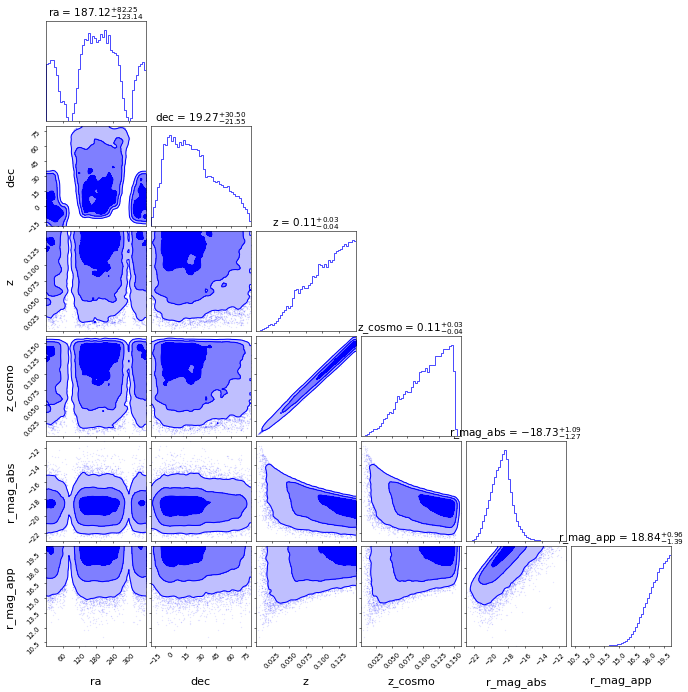

In [15]:
fig = corner_(bgs_df[::50], var_names=['ra','dec','z','z_cosmo','r_mag_abs','r_mag_app'])

In [16]:
from skysurvey.target.snia import SNeIaMagnitude, SNeIaColor, SNeIaStretch
from skysurvey.target import Transient
from skysurvey.effects import dust
import numpy as np

def rand_positions(positions, size=1, weights=None, zcut=0.1):
    positions_ = positions[positions["z"] < zcut] 
    index = np.random.choice(positions_.index, size=size, p=weights)
    
    return (positions_.loc[index].reset_index()['ra'], positions_.loc[index].reset_index()['dec'], positions_.loc[index].reset_index()['z'])


class SNeIa_full_bgs( Transient ):

    _KIND = "SNIa"
    _TEMPLATE = "salt2"
    _RATE = 2.35 * 10**4 # Perley 2020

    # {'model': func, 'prop': dict, 'input':, 'as':}
    _MODEL = dict( redshift = {"kwargs": {"zmax":0.2}},
                   
                   x1 = {"func": SNeIaStretch.nicolas2021}, 
                   
                   c = {"func": SNeIaColor.intrinsic_and_dust},

                   t0 = {"func": np.random.uniform, 
                         "kwargs": {"low":58179, "high":59215} },
                       
                   magabs = {"func": SNeIaMagnitude.tripp1998,
                             "kwargs": {"x1": "@x1", "c": "@c",
                                        "mabs":-19.3, "sigmaint":0.10}
                            },
                           
                   magobs = {"func": "magabs_to_magobs", # defined in Target (mother of Transients)
                             "kwargs": {"z":"@z", "magabs":"@magabs"},
                            },
                   x0 = {"func": "magobs_to_amplitude", # defined in Transients
                         "kwargs": {"magobs":"@magobs", "param_name": "x0"},
                        }, #because it needs to call sncosmo_model.get(param_name)
                       
                   radecz = {"func": rand_positions,
                            "kwargs": {'positions':bgs_df, 'zcut':0.06}, 
                            "as": ["ra","dec","z"]
                           },
                        
                   mwebv = {"func": dust.get_mwebv, "kwargs":{"ra":"@ra", "dec":"@dec"}}
                    
                    )


In [18]:
survey = extract_ztf()
survey.date_range

(58288.17, 59211.227)

In [19]:
snia = SNeIa_full_bgs()
# data = snia.draw(size=10000, inplace=True,  zmax=0.06)
data = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)

z=0.06, z=0.1

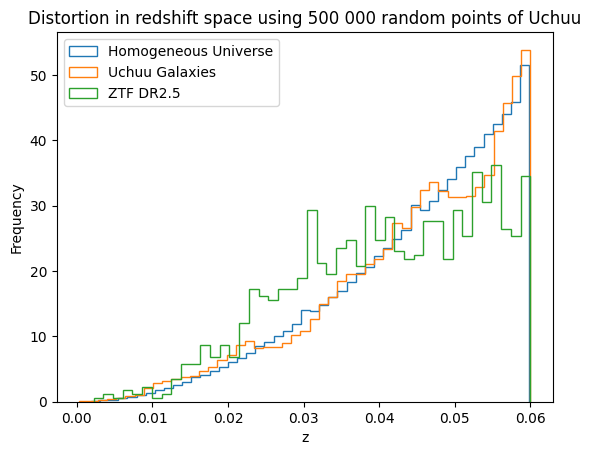

In [197]:
%matplotlib inline
snia.data['redshift'].plot.hist(bins=49, histtype='step', label='Homogeneous Universe', density=True)
snia.data['z'].plot.hist(bins=49, histtype='step', label='Uchuu Galaxies', density=True)
ztf_sn[ztf_sn['z'] < 0.06]['z'].plot.hist(bins=45, histtype='step', label='ZTF DR2.5', density=True)
plt.legend()
plt.xlabel('z')
plt.title('Distortion in redshift space using 500 000 random points of Uchuu')
plt.savefig('../figures/Redshift_distortion.png')

### FIT COSMO

In [20]:
snia_default = skysurvey.SNeIa()
_ = snia_default.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], inplace=True,  zmax=0.06)
# _ = snia_default.draw(size=10000, inplace=True,  zmax=0.06)

<Axes: xlabel='z', ylabel='magobs'>

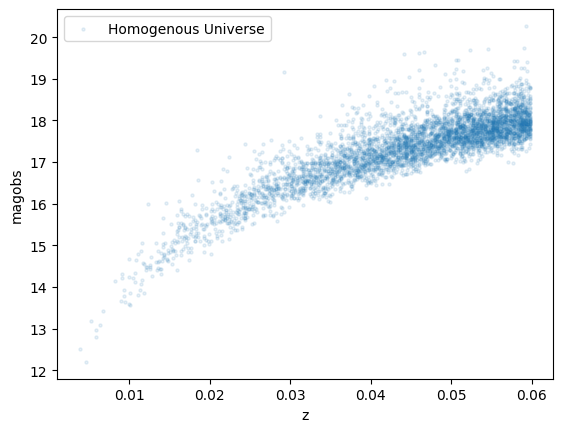

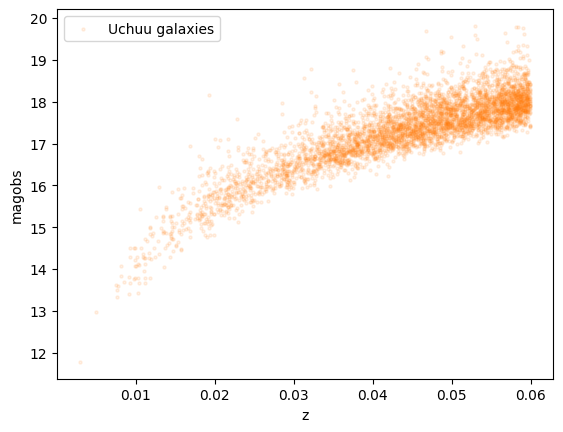

In [21]:
snia_default.data.plot.scatter('z','magobs', marker='.', alpha=0.1, color='tab:blue', label='Homogenous Universe')
# plt.savefig("../figures/homogeneous_magobs_z.png")
snia.data.plot.scatter('z','magobs', marker='.', alpha=0.1, color='tab:orange', label='Uchuu galaxies')
# plt.savefig("../figures/Uchuu_magobs_z.png")

In [22]:
from astropy.constants import c
from scipy.integrate import quad
from astropy.cosmology import Planck18 as cosmo
cosmo.Ogamma0 + cosmo.Onu0, cosmo.Om0, cosmo.Ode0, cosmo.H0.value

(0.0014936944554559178, 0.30966, 0.6888463055445441, 67.66)

In [23]:
def dist(z, Omega_r, Omega_m, Omega_l, H0):
    Omega_k = 1. - Omega_m - Omega_l - Omega_r
    return quad(lambda z1 : (Omega_m*(1+z1)**3 + Omega_r*(1+z1)**4 + Omega_k*(1+z1)**2 + Omega_l)**(-0.5)*c.value*10**(-3)/H0, 0, z)

dist_vec = np.vectorize(dist)

def f(z, Omega_m, Omega_r=cosmo.Ogamma0 + cosmo.Onu0, H0=cosmo.H0.value, Omega_l=cosmo.Ode0):
    return 5.0 * np.log10(abs((z + 1.0) * dist_vec(z, Omega_r, Omega_m, Omega_l, H0)[0])) + 25

In [24]:
from scipy.optimize import curve_fit

popt_uchuu, pcov_uchuu = curve_fit(f,
                       np.array(snia.data['z']),
                       np.array(snia.data['magobs'] - snia.data['magabs'].mean()),
                       p0=[cosmo.Om0],
                       bounds=([0.2],[0.4])
                      )

In [25]:
print("O_m = {}".format(*popt_uchuu))

O_m = 0.3559588165726197


In [26]:
popt_def, pcov_def = curve_fit(f,
                       np.array(snia_default.data['z']),
                       np.array(snia_default.data['magobs'] - snia_default.data['magabs'].mean()),
                       p0=[cosmo.Om0],
                       bounds=([0.2],[0.4])
                      )

In [27]:
print("\nO_m = {}".format(*popt_def))


O_m = 0.30726031660545156


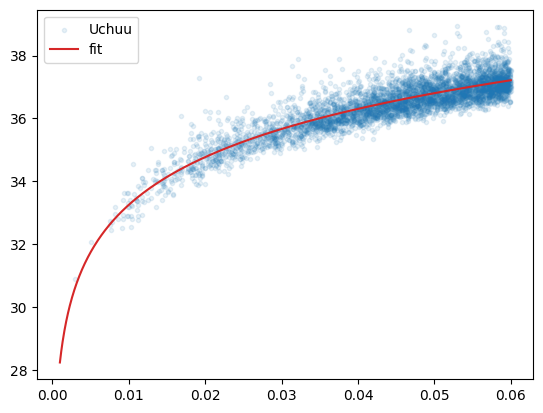

In [28]:
plt.scatter(snia.data['z'],np.array(snia.data['magobs'] - snia.data['magabs'].mean()), marker='.', alpha=0.1, color='tab:blue', label='Uchuu')

plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_uchuu), label="fit", color='tab:red')
plt.legend()

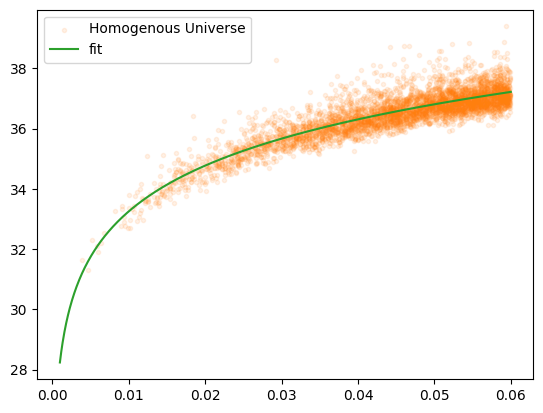

In [29]:
plt.scatter(snia_default.data['z'], snia_default.data['magobs'] - snia_default.data['magabs'].mean(), marker='.', alpha=0.1, color='tab:orange', label='Homogenous Universe')
plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_def), label="fit", color='tab:green')
plt.legend()

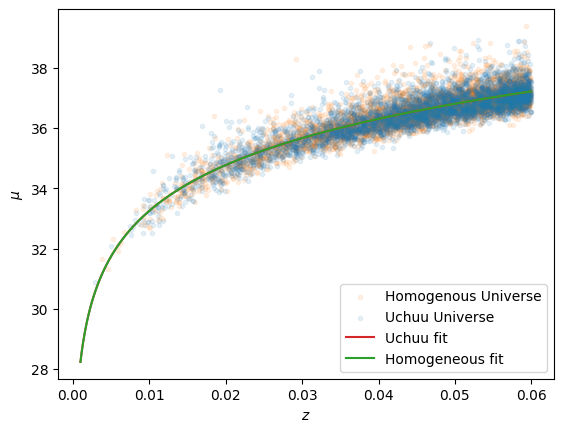

In [30]:
plt.scatter(snia_default.data['z'],np.array(snia_default.data['magobs'] - snia_default.data['magabs'].mean()), marker='.', alpha=0.1, color='tab:orange', label='Homogenous Universe')
plt.scatter(snia.data['z'],np.array(snia.data['magobs'] - snia.data['magabs'].mean()), marker='.', alpha=0.1, color='tab:blue', label='Uchuu Universe')

plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_uchuu), color='tab:red', label="Uchuu fit")
plt.plot(np.linspace(1e-3,0.06,1000), f(np.linspace(1e-3,0.06,1000),*popt_def), color='tab:green', label="Homogeneous fit")
plt.ylabel("$\mu$")
plt.xlabel("$z$")

plt.legend()
# plt.savefig('../figures/Homogenous_vs_uchuu_mag.png')

### LC

In [64]:
snia = SNeIa_full_bgs()
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[0]+100, inplace=True,  zmax=0.2)

In [65]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()

/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")
100%|██████████| 19388/19388 [01:48<00:00, 178.48it/s]
/global/homes/a/agillesl/.local/perlmutter/python-3.11/lib/python3.11/site-packages/skysurvey/dataset.py:154: FutureWarning: The behavior of pd.concat with len(keys) != len(objs) is deprecated. In a future version this will raise instead of truncating to the smaller of the two sequences
  data = pandas.concat(lightcurves, keys=fieldids # store fieldid


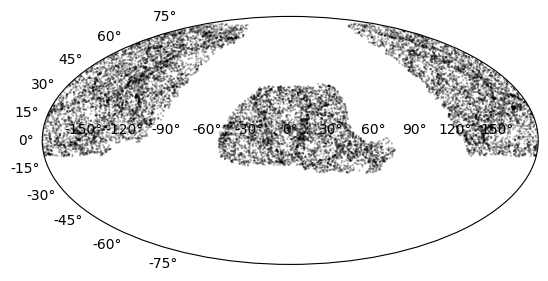

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
mollweide_scatter(dset.targets.data, ax=ax,)


In [66]:
ids = np.unique(list(map(lambda x : x[0], dset.data.index)))

In [67]:
from tqdm.notebook import tqdm
dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
dset.targets.data["keep"] = False
dset.targets.data["good"] = False
ids = np.unique(list(map(lambda x : x[0], dset.data.index)))
for i in tqdm(ids):
    target = dset.targets.data.loc[i]
    obs_data = dset.data.loc[i]
    dset.targets.data.loc[i,"keep"] = np.any(obs_data["time"].between(target["t0"] - 10, target["t0"] +20))
    dset.targets.data.loc[i,"good"] = dset.targets.data.loc[i,"keep"] and np.sum(obs_data[obs_data["detected"]]["time"].between(target["t0"] - 50, target["t0"]+200)) > 5

  0%|          | 0/16004 [00:00<?, ?it/s]

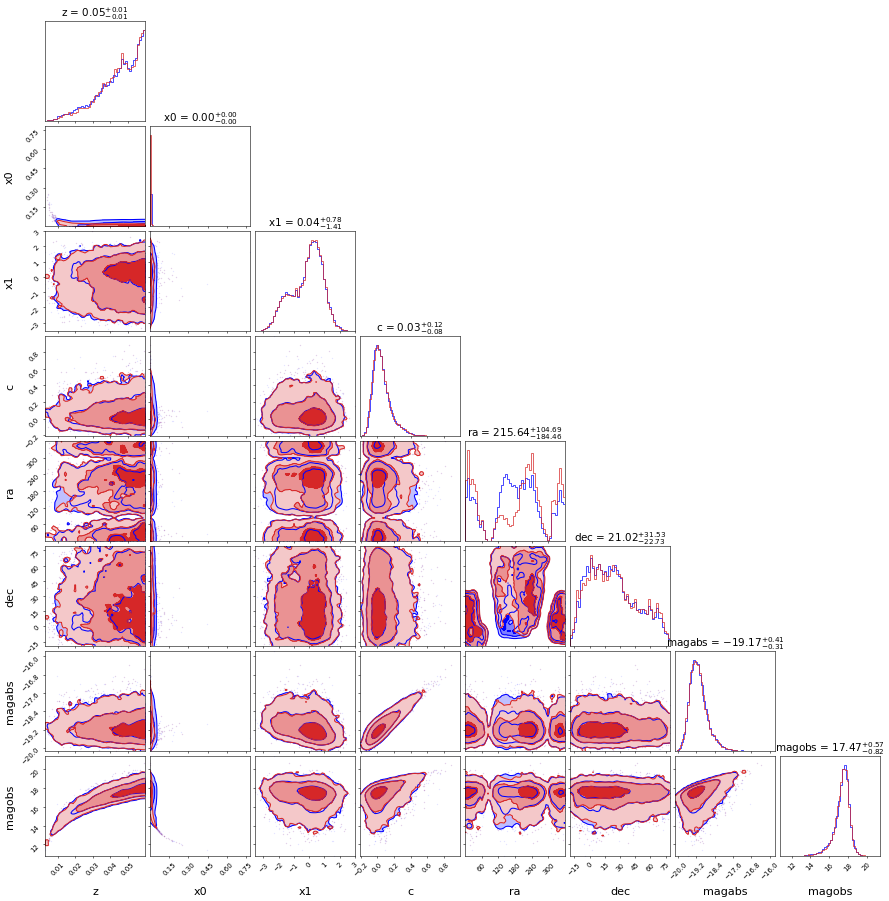

In [68]:
%matplotlib inline
fig = corner_(dset.targets.data,
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ])
_=corner_(dset.targets.data[dset.targets.data["keep"]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig = fig,
    color='tab:red')


Text(0.5, 1.0, 'Rate corrected')

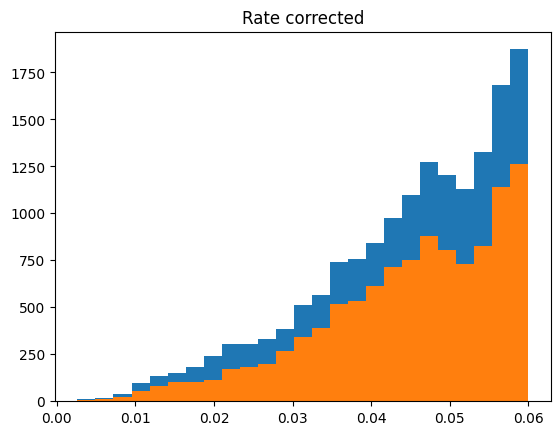

In [69]:
%matplotlib inline
_, bins,_ =plt.hist(dset.targets.data["z"], bins =25)
_ = plt.hist(dset.targets.data[dset.targets.data["keep"]]["z"], bins=bins)
plt.title('Rate corrected')

In [70]:
np.sum(dset.targets.data['good'])

9749

/tmp/ipykernel_2272314/2217368323.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot((bins[1:]+bins[:-1])/2, filtfilt([1/5]*5, 1, surv/full))


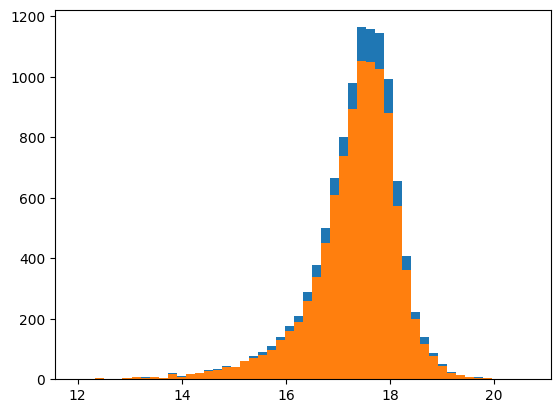

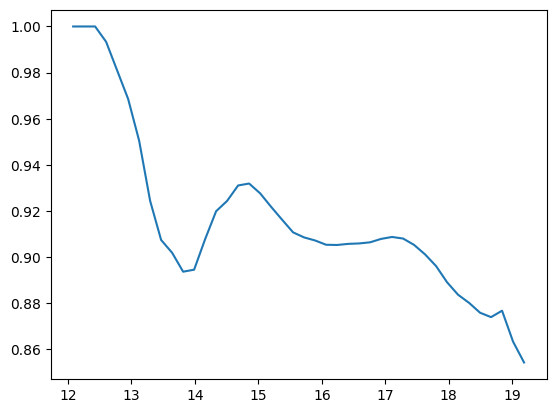

In [71]:
full, bins, _=plt.hist(dset.targets.data[dset.targets.data["keep"]]["magobs"], bins =50)
surv,_,_ = plt.hist(dset.targets.data[dset.targets.data["good"]]["magobs"], bins=bins)
plt.figure()
from scipy.signal import filtfilt
plt.plot((bins[1:]+bins[:-1])/2, filtfilt([1/5]*5, 1, surv/full))

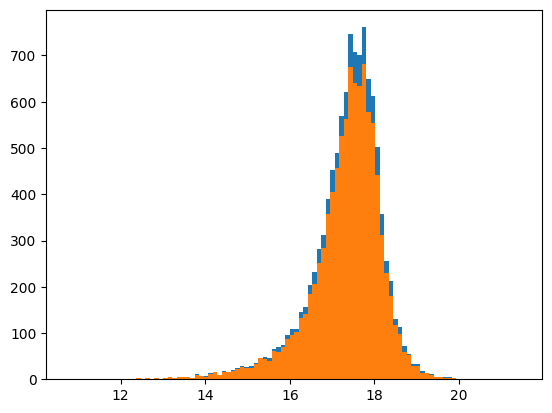

In [73]:
_,bins =np.histogram(dset.targets.data["magobs"], bins=100)
kept,_,_=plt.hist(dset.targets.data[dset.targets.data["keep"]]["magobs"], bins=bins)
good,_,_=plt.hist(dset.targets.data[dset.targets.data["good"]]["magobs"], bins=bins)

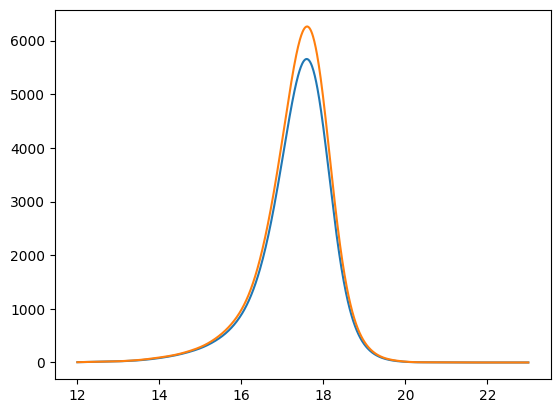

In [74]:
from scipy.stats import gaussian_kde
good_kde = gaussian_kde(dset.targets.data[dset.targets.data["good"]]["magobs"], bw_method=0.3)
kept_kde = gaussian_kde(dset.targets.data[dset.targets.data["keep"]]["magobs"], bw_method=0.3)

mag = np.linspace(12, 23, 1000)
plt.plot(mag, good_kde(mag)*np.sum(dset.targets.data["good"]))
plt.plot(mag, kept_kde(mag)*np.sum(dset.targets.data["keep"]))


In [75]:
mid = (bins[:-1] + bins[1:])/2
mid[kept > 0][[0,-1]]

array([11.995526, 20.632908], dtype=float32)

In [76]:
def sigmoid(x, alpha, beta):
    return 1/(1 + np.exp(alpha*(x-beta)))

In [ ]:
curve_fit(sigmoid, mag, good_kde(mag)*np.sum(dset.targets.data["good"])/(kept_kde(mag)*np.sum(dset.targets.data["keep"])))

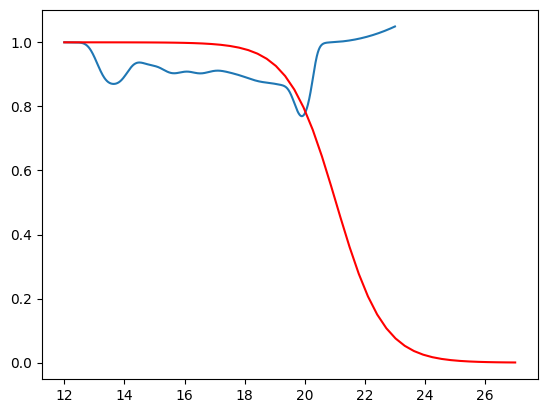

In [78]:
plt.plot(mag, good_kde(mag)*np.sum(dset.targets.data["good"])/(kept_kde(mag)*np.sum(dset.targets.data["keep"])))
plt.plot(np.linspace(12, 27), sigmoid(np.linspace(12, 27), 1.26505062, 21.03978649),'r')

ATTENTION 

In [ ]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=id_det,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

In [ ]:
nopes = np.where(np.any(np.array(n_det, dtype=tuple) == 0, axis=1))[0]

In [ ]:
from astropy.time import Time

for i in nopes[20:40]:
    _ = dset.show_target_lightcurve(index=detected[i])
    plt.ylim(-200)
    target = dset.targets.data.loc[detected[i]]
    plt.axvline(Time(target["t0"], format="mjd").datetime)

    plt.axvline(Time(target["t0"]-50, format="mjd").datetime, linestyle='dotted', c='k')
    plt.axvline(Time(target["t0"]+200, format="mjd").datetime, linestyle='dotted', c='k')
    
    plt.xlim(Time(target["t0"]-150, format="mjd").datetime, Time(target["t0"] +300, format="mjd").datetime)
    plt.title(f"Target {i}")


In [ ]:

better_results = pandas.DataFrame(
    {
        **{col: np.array(results["value"].loc[map(lambda x: (x, col), id_det)] - \
                      results["truth"].loc[map(lambda x: (x, col), id_det)])
        for col in guess.keys()},
        **{"err_"+col: np.array(results["error"].loc[map(lambda x: (x, col), id_det)]) for col in guess.keys()}
    }
)
better_results

In [ ]:
np.sum(~np.any(np.array(n_det[:400]) < 3, axis=1))

In [ ]:
fig = plt.figure(figsize=(15,15),dpi=60)
corner_(better_results,
    fig=fig,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:blue',
    show_titles=False)
corner_(better_results[better_results["t0"].between(-1,1)],
    fig=fig,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:red',
    show_titles=False)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)
# plt.savefig('../figures/Uchuu_reconstructed_cuts')

In [ ]:
from corner import quantile

filt= (better_results['err_t0'] < quantile(better_results["err_t0"].dropna(), q=0.98)[0]) \
    & (better_results['err_c'] < quantile(better_results["err_c"].dropna(), q=0.98)[0]) \
    & (better_results['err_x0'] < quantile(better_results["err_x0"].dropna(), q=0.98)[0]) \
    & (better_results['err_x1'] < quantile(better_results["err_x1"].dropna(), q=0.98)[0])
#    & np.all(np.array(n_det[:400]) >= 5, axis=1)
sum(filt)

In [ ]:
fig = corner_(dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')

_ = corner_(dset.targets.data.loc[id_det[better_results["t0"].between(-1,1)]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig=fig,
    color='tab:red',
    bins=30)

_ = corner_(dset.targets.data.loc[id_det[filt]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    fig=fig,
    color='tab:orange',
    bins=30)

In [ ]:
snia.data['redshift'].loc[detected].plot.hist(bins=1000, histtype='step', density=True, cumulative=True)
snia.data['redshift'].loc[id_det[filt]].plot.hist(bins=1000, histtype='step', density=True, cumulative=True)

In [ ]:
from corner import quantile
kept = better_results[filt].copy()

print(np.diff(quantile(better_results["err_t0"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_t0"].dropna(), q=[0.16,0.84])))
print(np.diff(quantile(better_results["err_x0"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_x0"].dropna(), q=[0.16,0.84])))
print(np.diff(quantile(better_results["err_x1"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_x1"].dropna(), q=[0.16,0.84])))
print(np.diff(quantile(better_results["err_c"].dropna(), q=[0.16,0.84]))/np.diff(quantile(kept["err_c"].dropna(), q=[0.16,0.84])))


In [ ]:
fig=corner_(better_results,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:blue')

_=corner_(kept,
    var_names=list(guess.keys()) + list(map(lambda x : "err_"+x, guess.keys())),
    color='tab:orange')
# plt.savefig('../figures/Uchuu_cut')

In [ ]:
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_t0"]==kept['err_t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_c"]==kept['err_c'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_x0"]==kept['err_x0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[kept[kept["err_x1"]==kept['err_x1'].max()].index[0]])

# ZTF position in Uchuu

In [3]:
bgs_df = load_bgs(columns=['RA', 'DEC', 'Z', 'Z_COSMO', 'STATUS', 'V_PEAK', 'V_RMS','R_MAG_ABS','R_MAG_APP'])

Found file ../../project/Projet-LPNHE/data/Uchuu.csv with columns Index(['r_mag_app', 'r_mag_abs', 'dec', 'ra', 'z_cosmo', 'z', 'v_peak',
       'v_rms', 'in_desi'],
      dtype='object')


In [42]:
ztf_sn = pandas.read_csv('data/data_ztf.csv', index_col=0)
ztf_sn

,z,ra,dec,mwebv,classification,sn,dr2,name,tmax,x0,x1,c,survey,valid,host,host_not_valid
0,0.061960,127.448018,33.906536,0.033335,snia-norm,0,1,ZTF17aadlxmv,58878.198049,0.001130,0.436035,0.076493,ZTF,1,47180340,False
5,0.070227,175.776516,15.567129,0.031559,snia,4,1,ZTF18aaaqexr,58893.891882,0.000614,-1.718682,0.054759,ZTF,1,61606285,False
17,0.026112,154.926636,43.366308,0.011640,snia-norm,16,0,ZTF18aabukgo,58784.197774,0.001703,0.786930,0.566200,ZTF,1,6768,False
21,0.062131,106.823644,43.316428,0.087386,snia,20,1,ZTF18aadzfso,58888.371168,0.000812,-0.345617,0.135708,ZTF,1,59183351,False
31,0.077847,230.519091,30.048732,0.018029,snia-pec-91t,30,1,ZTF18aahatvc,58986.320334,0.000960,0.969599,0.046395,ZTF,1,47797029,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,0.071356,184.013905,45.343774,0.010385,snia,3599,1,ZTF20acyybwo,59210.008904,0.000536,-1.994385,0.036207,ZTF,1,47843066,False
3624,0.222284,206.344125,39.738056,0.006524,snia-norm,3617,1,ZUDS20dlgrv,58889.199726,0.000098,-2.707063,-0.041313,ZTF,1,-1,True
3625,0.130567,219.245208,50.622639,0.013588,snia-norm,3618,0,ZUDS20dnrnc,58895.763443,0.000199,-2.148530,-0.199763,ZTF,1,53094290,False
3626,0.270223,224.032458,46.326417,0.012907,snia,3619,1,ZUDS20dofxx,58879.077624,0.000058,-0.717290,-0.131491,ZTF,1,-1,True


In [44]:
snia = SNeIa_full_bgs()
data = snia.draw(size=5000, inplace=True,  zmax=0.06)


In [ ]:
_=corner_(ztf_sn[ztf_sn['valid']==1],
        var_names=['ra','dec','z','tmax', 'x0', 'x1', 'c'])

In [45]:
%matplotlib inline

In [46]:
survey = extract_ztf()

ztf_sn = ztf_sn[ztf_sn['tmax'].between(survey.date_range[0], survey.date_range[1])].copy()
ztf_sn
nside = 128

In [48]:
ids = healpy.ang2pix(theta = np.pi/2 - ztf_sn['dec']*np.pi/180, phi=ztf_sn['ra']*np.pi/180, nside=nside)
map_ = np.zeros(healpy.nside2npix(nside))
for i in tqdm(ids):
    map_[i] += 1
map_ = healpy.smoothing(map_, fwhm=0.1)
map_ -= map_.min()
id_bgs = healpy.ang2pix(theta = np.pi/2 - bgs_df['dec']*np.pi/180, phi=bgs_df['ra']*np.pi/180, nside=nside)
mask = np.zeros(healpy.nside2npix(nside), dtype=bool)
for i in tqdm(id_bgs):
    mask[i] = True
#map_[~mask]=0
map_ /= np.sum(map_)

z_nside = 64
id_bgs = healpy.ang2pix(theta = np.pi/2 - bgs_df['dec']*np.pi/180, phi=bgs_df['ra']*np.pi/180, nside=z_nside)
bgs_pix = [[]]*healpy.nside2npix(z_nside)
for i,nb_pix in tqdm(enumerate(id_bgs), total = len(id_bgs)):
    bgs_pix[nb_pix] = bgs_pix[nb_pix] + [id_bgs.index[i]]

bgs_pix = [np.array(bgs_df.loc[ids]['z']) for ids in bgs_pix]

  0%|          | 0/3170 [00:00<?, ?it/s]

  0%|          | 0/4698044 [00:00<?, ?it/s]

  0%|          | 0/4698044 [00:00<?, ?it/s]

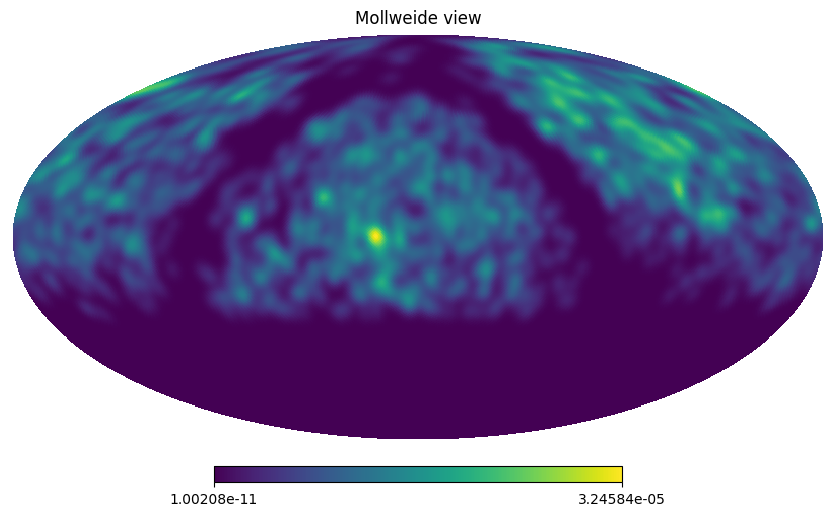

In [49]:
healpy.mollview(map_)

  0%|          | 0/100000 [00:00<?, ?it/s]

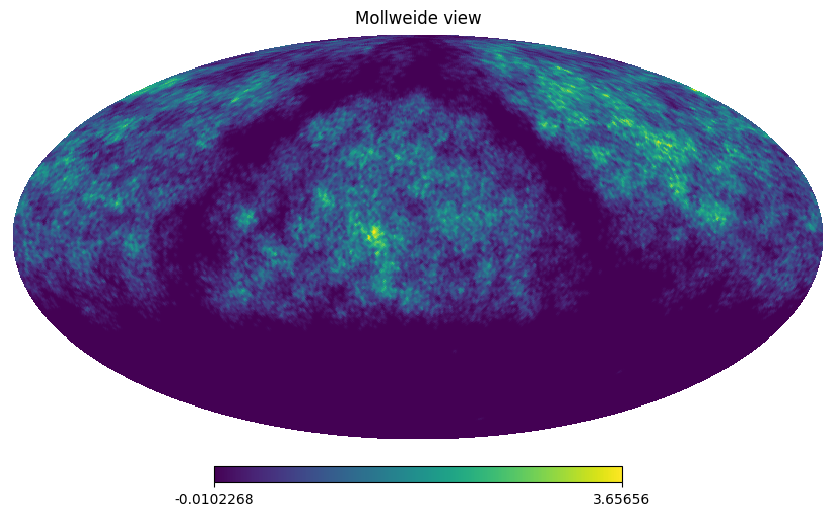

In [50]:
spl = np.random.choice(np.arange(healpy.nside2npix(nside)), size=100000, p=map_)
map_sampled = np.zeros(healpy.nside2npix(nside))
for i in tqdm(spl):
    map_sampled[i] += 1
map_sampled = healpy.smoothing(map_sampled, fwhm=0.02)

healpy.mollview(map_sampled)

In [51]:
healpy.ang2pix(z_nside, *healpy.pix2ang(nside, spl))

array([19180,  6003, 16408, ...,   468, 23826,  7955])

In [52]:
np.where([len(l)>0 for l in bgs_pix])[0]

array([  385,   386,   389, ..., 32684, 32685, 32937])

In [53]:
def rand_ztf_positions(maps, size=1, zcut=0.1):
    ztf_map, bgs_redshifts = maps
    ztf_nside = healpy.npix2nside(len(ztf_map))
    bgs_nside = healpy.npix2nside(len(bgs_nside))
    
    sampled_pix = np.random.choice(np.arange(healpy.nside2npix(nside)), size=size, p=ztf_map)
    
    bgs_sampled_pix = healpy.ang2pix(bgs_nside, *healpy.pix2ang(ztf_nside, spl))
    
    for angpix, zpix in zip(sampled_pix,bgs_sampled_pix):
        new_ra, new_dec = draw_from_pixel(angpix, ztf_nside)
        ra.append(new_ra)
        dec.append(new_dec)

        kde = gaussian_kde(bgs_redshifts[zpix])
        z.append(kde.resample(1)[0][0])

    return(ra, dec, z)

def draw_from_pixel(pix, nside):
    boundaries_theta,boundaries_ra = healpy.vec2ang(healpy.boundaries(nside, pix).T)
    boundaries_dec = np.pi/2 - boundaries_theta
    boundaries_ra = boundaries_ra[(boundaries_dec != -np.pi/2) & (boundaries_dec != np.pi/2)]

    min_, max_ = np.min(boundaries_ra), np.max(boundaries_ra)
    if max_-min_>= 2*np.pi-np.pi/nside:
        boundaries_ra[boundaries_ra < np.pi]+= 2*np.pi
    min_, max_ = np.min(boundaries_ra),np.max(boundaries_ra)

    in_pix = False
    while not in_pix:
        draw_ra = np.random.uniform(min_, max_)
        draw_ra -= 2*np.pi*(draw_ra > 2*np.pi)
        draw_dec = np.arcsin(np.random.uniform(np.min(np.sin(boundaries_dec)), np.max(np.sin(boundaries_dec))))
        in_pix = (pix == healpy.ang2pix(nside, 0.5 * np.pi - draw_dec, draw_ra))
    
    return np.array([draw_ra, draw_dec])


In [54]:
with open("data/bgs_redshifts_map.pkl", "wb") as fp:
    pickle.dump(bgs_pix, fp)

55


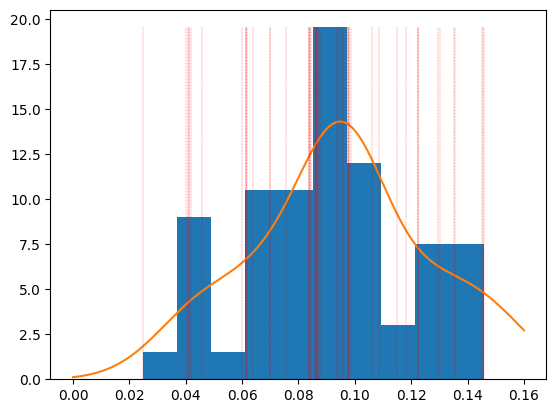

In [72]:
from scipy.stats import gaussian_kde
pix = 32684
print(len(bgs_pix[pix]))
if len(bgs_pix[pix]) > 0:
    h,_,_=plt.hist(bgs_pix[pix], density=True)
    kde = gaussian_kde(bgs_pix[pix])
    _=plt.plot(np.linspace(0, 0.16, 1000), kde.pdf(np.linspace(0, 0.15, 1000)))
    _=plt.vlines(bgs_pix[pix], 0,np.max(h), color='r', linestyle='--', linewidth=0.2)

  0%|          | 0/4698044 [00:00<?, ?it/s]

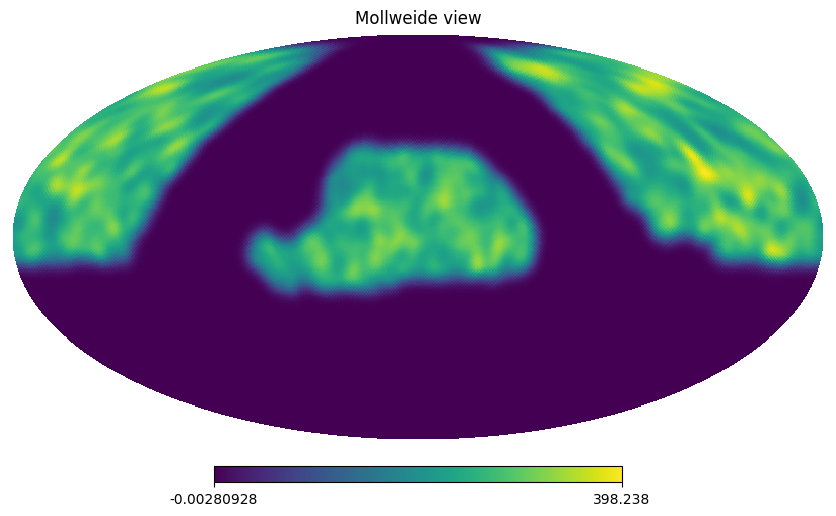

In [73]:
map_bgs = np.zeros(healpy.nside2npix(64))
for i in tqdm(id_bgs):
    map_bgs[i] += 1
map_bgs = healpy.smoothing(map_bgs, fwhm=0.1)
healpy.mollview(map_bgs)

In [ ]:
start = time.time()
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)
stop = time.time()
time.strftime('%H:%M:%S', time.gmtime(stop - start))

In [ ]:
det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index
len(detected)

In [ ]:
def detection_av_ap(dset, detected):
    n_det = []
    dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
    for i in tqdm(detected):
        target = dset.targets.data.loc[i]
        obs_data = dset.data[dset.data["detected"]].loc[i]
        n_det.append((np.sum(obs_data["time"].between(target["t0"] - 50, target["t0"])), np.sum(obs_data["time"].between(target["t0"], target["t0"]+200))))
    return detected[~np.any(np.array(n_det) < 3, axis=1)]
        
id_det = detection_av_ap(dset, detected)

In [ ]:
def fit_lc(dset, id_det):
    fixed = {"z": dset.targets.data.loc[id_det]["z"]}

    guess = {
        "t0": dset.targets.data.loc[id_det]["t0"],
        "c": dset.targets.data.loc[id_det]["c"],
        "x0": dset.targets.data.loc[id_det]["x0"],
        "x1": dset.targets.data.loc[id_det]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[id_det]["t0"].apply(lambda x: [x-5, x+5]),
        "c": dset.targets.data.loc[id_det]["c"].apply(lambda x: [-0.3, 1.0]),
        "x0": dset.targets.data.loc[id_det]["x0"].apply(lambda x: [-0.1, 0.1]),
        "x1": dset.targets.data.loc[id_det]["x1"].apply(lambda x: [-4, 4]),
    }

    results, meta = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=id_det,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
    )

    better_results = pandas.DataFrame(
        {
            **{col: np.array(results["value"].loc[map(lambda x: (x, col), id_det[:400])] - \
                          results["truth"].loc[map(lambda x: (x, col), id_det[:400])])
            for col in guess.keys()},
            **{"err_"+col: np.array(results["error"].loc[map(lambda x: (x, col), id_det[:400])]) for col in guess.keys()}
        }
    )
    return better_results

In [ ]:
results_ztf = fit_lc(dset, id_det[:400])

In [ ]:
fig=corner_(results_ztf,
    fig=plt.figure(figsize=(20,20)),
    var_names=list(guess.keys()),
    color='tab:blue')

In [ ]:
snia_bgs = SNeIa_full_bgs()

In [ ]:
snia_bgs.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)
dset_bgs = skysurvey.DataSet.from_targets_and_survey(snia_bgs, survey)

In [ ]:
det = dset_bgs.get_ndetection(detlimit=7) > 10
detected_bgs = det[det].index
id_det_bgs = detection_av_ap(dset_bgs, detected_bgs)

In [ ]:
_=plt.hist(snia_bgs.data['redshift'], bins=50, histtype='step', density=True)
_=plt.hist(snia_bgs.data['z'], bins=50, histtype='step', density=True)
_=plt.hist(snia.data['z'], bins=50, histtype='step', density=True)

In [ ]:
fig =corner_(snia_bgs.data, ['ra','dec','z'], fig=plt.figure(figsize=(15,15)), color='tab:blue', bins=30)
_=corner_(snia.data, ['ra','dec','z'], fig=fig, color='tab:red', bins=30)


In [ ]:
fig =corner_(snia_bgs.data.loc[id_det_bgs], ['ra','dec','z'], fig=plt.figure(figsize=(15,15)), color='tab:blue', bins=30)
_=corner_(snia.data.loc[id_det], ['ra','dec','z'], fig=fig, color='tab:red', bins=30)


In [ ]:
results_bgs = fit_lc(dset_bgs, id_det_bgs[:400])

In [ ]:
fig=corner_(results_bgs,
    fig=plt.figure(figsize=(20,20)),
    var_names=list(guess.keys()),
    color='tab:red')

_=corner_(better_results,
    fig=fig,
    var_names=list(guess.keys()),
    color='tab:blue')


# EDRIS

In [79]:
import jax
jax.config.update('jax_debug_nans', True)
jax.config.update("jax_enable_x64", True)


In [82]:
survey = extract_ztf()
survey.date_range

(58288.17, 59211.227)

In [83]:
# snia = SNeIa_full_bgs()
# _ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1], zmax=0.06, inplace=True)

In [84]:
# dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

In [8]:
from tqdm.notebook import tqdm
dset.data["detected"] = (dset.data["flux"]/dset.data["fluxerr"]) > 5
dset.targets.data["keep"] = False
dset.targets.data["good"] = False
ids = np.unique(list(map(lambda x : x[0], dset.data.index)))
for i in tqdm(ids):
    target = dset.targets.data.loc[i]
    obs_data = dset.data.loc[i]
    dset.targets.data.loc[i,"keep"] = np.any(obs_data["time"].between(target["t0"] - 10, target["t0"] +20))
    dset.targets.data.loc[i,"good"] = dset.targets.data.loc[i,"keep"] and np.sum(obs_data[obs_data["detected"]]["time"].between(target["t0"] - 50, target["t0"]+200)) > 5

  0%|          | 0/3283 [00:00<?, ?it/s]

In [85]:
to_run = np.where(dset.targets.data["good"])[0]

In [86]:
len(to_run)

9749

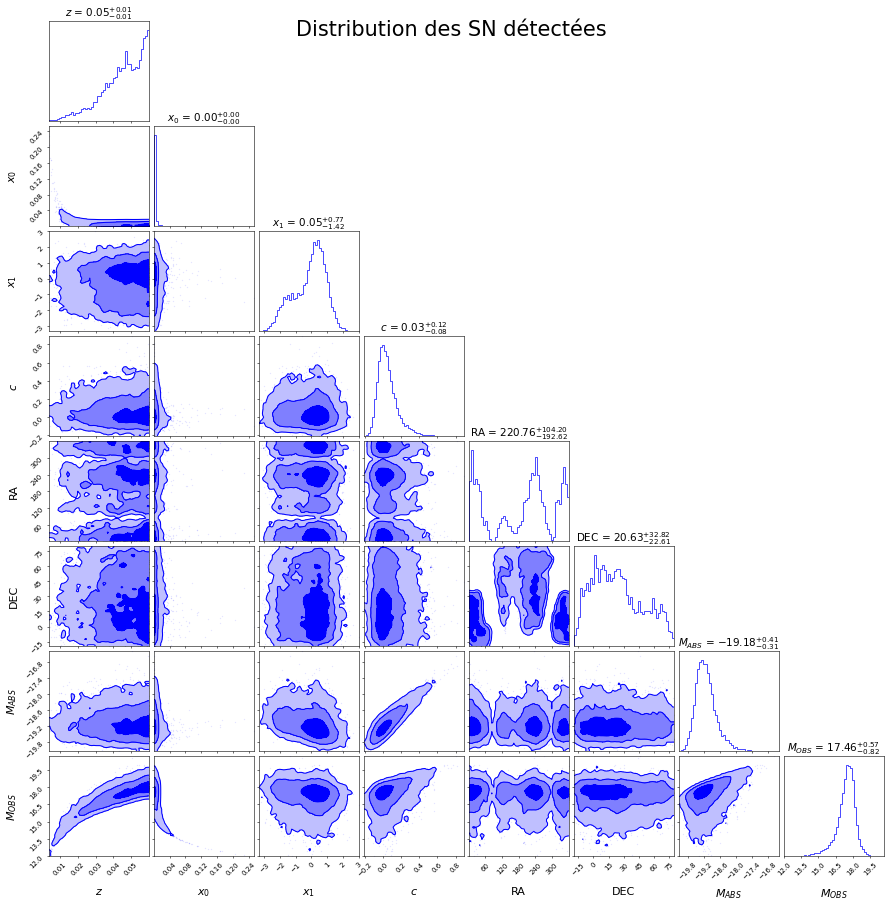

In [125]:
fig = corner_(dset.targets.data[dset.targets.data["good"]],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$M_{ABS}$",
        r"$M_{OBS}$",
    ], title='Distribution des SN détectées')


In [110]:
def fit_lc(dset, id_det):
    fixed = {"z": dset.targets.data.loc[id_det]["z"]}

    guess = {
        "t0": dset.targets.data.loc[id_det]["t0"],
        "c": dset.targets.data.loc[id_det]["c"],
        "x0": dset.targets.data.loc[id_det]["x0"],
        "x1": dset.targets.data.loc[id_det]["x1"],
    }
    bounds = {
        "t0": dset.targets.data.loc[id_det]["t0"].apply(lambda x: [x-5, x+5]),
        "c": dset.targets.data.loc[id_det]["c"].apply(lambda x: [-0.3, 1.0]),
        "x0": dset.targets.data.loc[id_det]["x0"].apply(lambda x: [-0.1, 0.1]),
        "x1": dset.targets.data.loc[id_det]["x1"].apply(lambda x: [-4, 4]),
    }

    results, meta = dset.fit_lightcurves(
        source=sncosmo.Model("salt2"),
        index=id_det,
        use_dask=False,
        fixedparams=fixed,
        guessparams=guess,
        bounds=bounds,
    )

    better_results = pandas.DataFrame(
        {
            **{col: np.array(results["value"].loc[map(lambda x: (x, col), id_det)] - \
                          results["truth"].loc[map(lambda x: (x, col), id_det)])
            for col in guess.keys()},
            **{"err_"+col: np.array(results["error"].loc[map(lambda x: (x, col), id_det)]) for col in guess.keys()}
        }
    )
    return results, better_results

In [89]:
res, b_res = fit_lc(dset, to_run[:400])

100%|██████████| 400/400 [03:53<00:00,  1.72it/s]


In [244]:
covariances = {i: np.array(res.loc[1].loc[["x0","x1","c"]][["cov_x0", "cov_x1", "cov_c"]]) for i in to_run[:400]}

In [245]:
stacked_res = pandas.DataFrame({**{col: np.array(res["value"].loc[map(lambda x: (x, col), to_run[:400])]) for col in ["x0","x1","c"]}}, index=to_run[:400])


In [248]:
covariances[1], stacked_res.loc[1]

(array([[ 3.58397729e-11, -2.48321280e-07, -2.90002731e-08],
        [-2.48321280e-07,  6.06391560e-03,  1.95350452e-04],
        [-2.90002731e-08,  1.95350452e-04,  2.79988074e-05]]),
 x0    0.000971
 x1    0.558085
 c     0.081263
 Name: 1, dtype: float64)

In [253]:
-2.5/(np.log(10)*0.000971)

-1118.16292972001

In [ ]:
(dset.targets.data.loc[to_run[:400]]['magobs'] + 2.5*np.log10(dset.targets.data.loc[to_run[:400]]['x0'])).mean()

10.501612

In [257]:
def X0X1C_to_MX1C(values, cov):
    new_values = values.copy()
    new_values["Mb"] = - 2.5*np.log10(values["x0"])
    new_covs = {i: jnp.matmul(jnp.matmul(jnp.array([[-2.5/(np.log(10)*values["x0"].loc[i]),0,0], [0,1,0], [0,0,1]]), covariances[1]),
                              jnp.array([[-2.5/(np.log(10)*values["x0"].loc[i]),0,0], [0,1,0], [0,0,1]])) for i in values.index}
    return new_values, new_covs

In [259]:
values, cov = X0X1C_to_MX1C(stacked_res, covariances)

In [322]:
# A bit of black magic reordering
from scipy.linalg import block_diag
full_matrix = block_diag(*[cov[i] for i in cov.keys()])
full_cov_sorted = full_matrix[:,[*[3*i for i in range(400)], *[3*i+1 for i in range(400)], *[3*i+2 for i in range(400)]]]\
                             [[*[3*i for i in range(400)], *[3*i+1 for i in range(400)], *[3*i+2 for i in range(400)]],:]

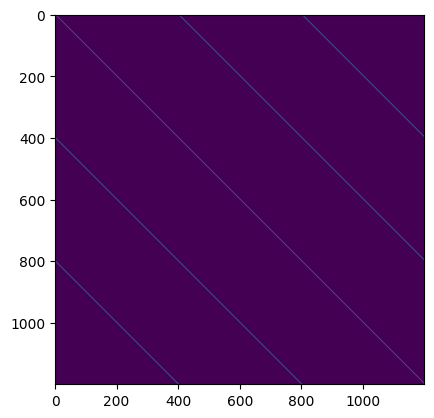

In [336]:
plt.imshow(full_cov_sorted > 0)


(array([ 3.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,  3.,  4., 12., 10., 18.,
        21., 33., 40., 52., 57., 58., 79.]),
 array([33.48784637, 33.67430878, 33.86077499, 34.04724121, 34.23370361,
        34.42016602, 34.60663223, 34.79309845, 34.97956085, 35.16602325,
        35.35248947, 35.53895569, 35.72541809, 35.91188049, 36.09834671,
        36.28481293, 36.47127533, 36.65773773, 36.84420395, 37.03067017,
        37.21713257]),
 <BarContainer object of 20 artists>)

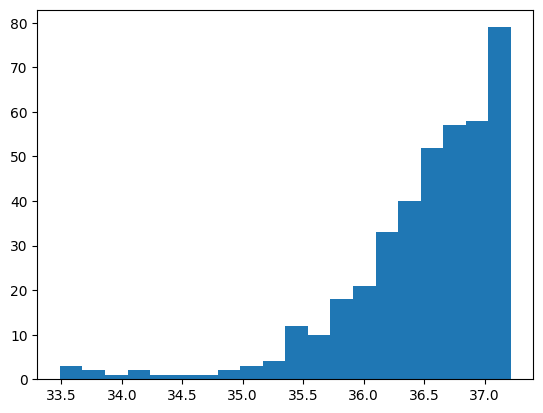

In [97]:
%matplotlib inline
plt.hist(dset.targets.data.loc[to_run[:400]]['magobs'] - dset.targets.data.loc[to_run[:400]]['magabs'], bins=20)

In [137]:
import jax.numpy as jnp
var = jnp.array(stacked_res['c'].to_list())

In [138]:
mag = jnp.array((dset.targets.data.loc[to_run[:400]]['magobs']-dset.targets.data.loc[to_run[:400]]['magabs']).to_list())

from edris.models import Obs

obs = Obs(mag, var)

In [132]:
exp = {'z': jnp.array(dset.targets.data.loc[to_run[:400]]["z"].to_list()),
       'z_bins':jnp.linspace(1e-6,0.06,10)}

In [133]:
exp

{'z': Array([0.05713442, 0.03710875, 0.05695158, 0.04272424, 0.05018507,
        0.04653011, 0.04998713, 0.03452571, 0.04864107, 0.04376841,
        0.0532076 , 0.04261887, 0.04962659, 0.04620722, 0.04363877,
        0.05105721, 0.03167113, 0.04636673, 0.04947386, 0.01819034,
        0.0570131 , 0.02272532, 0.03675404, 0.01924973, 0.02613434,
        0.04769974, 0.04626868, 0.05506517, 0.03843627, 0.03654426,
        0.05441408, 0.03524303, 0.05800704, 0.02703706, 0.02676459,
        0.05414821, 0.05175649, 0.05584111, 0.04753254, 0.04804717,
        0.04452636, 0.0360746 , 0.04949628, 0.04290677, 0.03917468,
        0.03619626, 0.04176884, 0.04093287, 0.05704276, 0.04575014,
        0.03172431, 0.05277387, 0.05205416, 0.04719134, 0.05240758,
        0.04898258, 0.05436371, 0.04524769, 0.04516742, 0.04891335,
        0.04705216, 0.04068406, 0.05886801, 0.05608005, 0.04508167,
        0.03110975, 0.05016722, 0.059267  , 0.03535   , 0.03314546,
        0.04688976, 0.04663146, 0.05838915,

In [237]:
from astropy.cosmology import Planck18 as cosmo
params = {'mu_bins': jnp.array(cosmo.distmod(np.array(exp['z_bins']))),
         'coef': jnp.array([3.15]),
         'variables': jnp.array([obs.variables.copy()]),
         'M0':10.501611}

In [148]:
from edris.models import FullCovariance

In [151]:
FullCovariance?

Init signature: FullCovariance(cov_mm, cov_xx, cov_mx)
Docstring:      <no docstring>
File:           /global/u1/a/agillesl/Documents/project/edris/edris/models.py
Type:           type
Subclasses:     

In [158]:
interpol_matrix = edris.tools.linear_interpolation_matrix(jnp.log10(exp['z']), jnp.log10(exp['z_bins']))

In [159]:
jnp.dot(interpol_matrix.T, obs.mag)

Array([   0.        ,   27.39058489,  248.90704655,  242.46055885,
        866.58646322, 1554.27241481, 2678.91220816, 3462.10855793,
       3434.20782014, 2080.32179922], dtype=float64)

In [155]:
mu_start = jnp.linalg.solve(jnp.dot(interpol_matrix.T, interpol_matrix), jnp.dot(interpol_matrix.T, obs.mag))
x0 = {'mu_bins':mu_start,
        'coef':jnp.array([3.1]),
        'variables':jnp.array([obs.variables])
}


FloatingPointError: invalid value (nan) encountered in jit(triangular_solve). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

In [4]:
pandas.read_csv('mock_ztf_spectra.csv', index_col=0)

,spec,time,wavelength,flux,fluxerr,valid,exptime,snid,flux_true,x0,x1,c,t0,mwebv,z
0,0.0,58913.312,2919.465201,-3.517291e-17,9.330154e-19,1.0,NaN,0.0,-3.563942e-17,0.000627,0.965,0.014,58882.113,0.027905,0.082201
1,0.0,58913.312,2955.119969,-3.305974e-17,2.773066e-18,1.0,NaN,0.0,-3.444627e-17,0.000627,0.965,0.014,58882.113,0.027905,0.082201
2,0.0,58913.312,2990.774737,-1.465633e-17,4.650376e-19,1.0,NaN,0.0,-1.488885e-17,0.000627,0.965,0.014,58882.113,0.027905,0.082201
3,0.0,58913.312,3026.429505,5.211357e-18,1.791956e-19,1.0,NaN,0.0,5.121759e-18,0.000627,0.965,0.014,58882.113,0.027905,0.082201
4,0.0,58913.312,3062.084273,2.028181e-17,1.222801e-18,1.0,NaN,0.0,1.967041e-17,0.000627,0.965,0.014,58882.113,0.027905,0.082201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800598,4514.0,59022.273,10219.784758,2.947695e-18,1.934409e-21,1.0,NaN,4514.0,2.946728e-18,0.000236,0.105,0.071,59000.246,0.037201,0.115411
4800599,4514.0,59022.273,10221.965902,2.894390e-18,4.482537e-20,1.0,NaN,4514.0,2.916803e-18,0.000236,0.105,0.071,59000.246,0.037201,0.115411
4800600,4514.0,59022.273,10224.147046,2.918928e-18,6.363705e-20,1.0,NaN,4514.0,2.887109e-18,0.000236,0.105,0.071,59000.246,0.037201,0.115411
4800601,4514.0,59022.273,10226.328190,2.885792e-18,5.629215e-20,1.0,NaN,4514.0,2.857646e-18,0.000236,0.105,0.071,59000.246,0.037201,0.115411


# MOCKSURVEY

In [ ]:
import sncosmo
from mocksurvey.simulations import *


In [ ]:
survey = extract_ztf()
snia = SNeIa()
data = snia.draw(size=10000, inplace=True,  zmax=0.15)
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

det = dset.get_ndetection(detlimit=7) > 10
detected = det[det].index

In [ ]:
output = get_detected_sn(dset, detlimit=7, detnumber= 10, per_band=False)
output = get_sn_index(output)
output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)
output = eliminate_points_not_in_model(output, snia)
output = get_trueflux_and_amplitude(output, snia)
output = get_snr(output)

In [ ]:
output = discard_small_snr(output, threshold=0)
output = discard_skysurvey_flux(output)

In [ ]:
output['survey'] = 'ztf'

In [ ]:
output.to_csv("tests.csv", encoding='utf-8', index=False)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def f(x, a, b, c):
    """
    """
    return a*x**2 + b*x + c


def generate_mock_sample(mock_ztf_path):
    """
    Generates the mock sample based on the generated mock survey.
    
    !! Need to generate the mock sample first
    
    Parameters:
    ------------
    mock_ztf_path : str
        Path to the generated ztf mock sample
    
    Returns:
    ------------
    : pandas.DataFrame
        Mock spectra
    
    """
    d_time = np.array([])
    d_wavelength = np.array([])
    d_flux = np.array([])
    d_fluxerr = np.array([])
    d_valid = np.array([])
    d_spec = np.array([])
    d_exptime = np.array([])
    d_snid = np.array([])
    d_flux_true = np.array([])
    d_x0 = np.array([])
    d_x1 = np.array([])
    d_c = np.array([])
    d_t0 = np.array([])
    d_mwebv = np.array([])
    d_z = np.array([])
    
    mock_survey = pd.read_csv(mock_ztf_path)
    idx = mock_survey['fluxtrue']!=0
    mock_survey = mock_survey[idx]
    
    mock_x0 = mock_survey['x0']
    mock_x1 = mock_survey['x1']
    mock_c = mock_survey['c']
    mock_t0 = mock_survey['t0']
    mock_z = mock_survey['z']
    mock_mwebv = mock_survey['mwebv']
    mock_snid = np.unique(mock_survey['snid'])
    
    
    n = len(mock_snid)
    length_wave = np.array([218, 437, 3258, 656, 868])
    popt = np.array([-7.87649259e-07,  1.08382223e-02, -2.44390307e+01])
    a, b, c = popt
    for i in tqdm(range(n)):
        x0 = np.array(mock_x0[mock_survey['snid']==i])[0]
        x1 = np.array(mock_x1[mock_survey['snid']==i])[0]
        c = np.array(mock_c[mock_survey['snid']==i])[0]
        t0 = np.array(mock_t0[mock_survey['snid']==i])[0]
        z = np.array(mock_z[mock_survey['snid']==i])[0]
        mwebv = np.array(mock_mwebv[mock_survey['snid']==i])[0]
        
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900., 3400.)
        max_wave = np.random.uniform(9000., 11000.)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        mjd = np.random.choice(mock_survey['time'][mock_survey['snid']==i])
        
        source = sncosmo.get_source('salt2', version='2.4')
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source=source, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
        
        p = {'z':z, 't0':t0, 'x0':x0, 'x1': x1, 'c': c, 'ebv':mwebv, 'r_v':3.1}
        model.parameters = list(p.values()) 
        
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                flux_true = model.flux(mjd, wavelength[wavelength<max_w])
                wavelength = wavelength[wavelength<max_w]
            except:
                flux_true = model.flux(mjd, wavelength[wavelength>min_w])
                wavelength = wavelength[wavelength>min_w]
        #j = np.random.randint(0, N)
        #err_ = spec_data['fluxerr'][j]
        #flx_ = spec_data['flux'][j]
        #norm = flx_/np.max(flux_true)

        #if norm == norm and norm != np.inf and norm != -np.inf:
        #    flux_true *= norm
        #flux_err = err_*np.random.randn(len(flux_true))
        norm_values = np.array([1,1,1,1,1,1,1,1,1,1E+12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true/f(wavelength, a, b, c)) *np.random.randn(len(flux_true))
        flux = flux_true + 0.5*flux_err
        
        d_time = np.append(d_time, np.repeat(mjd, len(flux)))
        d_wavelength = np.append(d_wavelength, wavelength)
        d_flux = np.append(d_flux, flux)
        d_fluxerr = np.append(d_fluxerr, np.abs(flux_err))
        d_flux_true = np.append(d_flux_true, flux_true)
        d_valid = np.append(d_valid, np.repeat(1, len(flux)))
        d_exptime = np.append(d_exptime, np.repeat(np.nan, len(flux)))
        d_snid = np.append(d_snid, np.repeat(mock_snid[i], len(flux)))
        d_spec = np.append(d_spec, np.repeat(i, len(flux)))
        d_x0 = np.append(d_x0, np.repeat(x0, len(flux)))
        d_x1 = np.append(d_x1, np.repeat(x1, len(flux)))
        d_c = np.append(d_c, np.repeat(c, len(flux)))
        d_t0 = np.append(d_t0, np.repeat(t0, len(flux)))
        d_z = np.append(d_z, np.repeat(z, len(flux)))
        d_mwebv = np.append(d_mwebv, np.repeat(mwebv, len(flux)))
    data_sim = pd.DataFrame({'spec':d_spec, 'time': d_time, 
                             'wavelength': d_wavelength, 'flux': d_flux, 
                             'fluxerr': d_fluxerr, 'valid': d_valid, 
                             'spec': d_spec, 'exptime': d_exptime, 
                             'snid': d_snid, 'flux_true':d_flux_true,
                             'x0':d_x0, 'x1': d_x1, 'c':d_c, 't0':d_t0,
                             'mwebv':d_mwebv, 'z':d_z})
    return data_sim


In [ ]:
data_mock = generate_mock_sample('tests.csv')
data_mock.to_csv('mock_ztf_spectra.csv')

In [ ]:
%matplotlib inline

In [ ]:
data_mock=pandas.read_csv('mock_ztf_spectra.csv')

In [ ]:
%matplotlib inline

for i in tqdm(data_mock.groupby("spec")["spec"].mean()[::100]):
    plt.errorbar(data_mock[data_mock['spec']==i]["wavelength"], data_mock[data_mock['spec']==i]["flux"], data_mock[data_mock['spec']==i]["fluxerr"], capsize=2)
    
plt.xlabel('wavelength')
plt.ylabel('flux')

In [ ]:
# ztf_targets, ztf_survey, ztf_dset, ztf_raw = build_output_to_compress(ztf, 0.0, 0, per_band=False, snr_threshold=0)